In [4]:
# 01/17/2020: using 20 threads, 50G
# 01/20/2020: using 20 threads, 40G
    #csv time: 4:57
    #dta time: 49min 39s

In [5]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Mon Jan 20 11:26:59 PST 2020


# Have a look at the DP error at census tract level

And dig in by ethnicity if time permist.

In [28]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']


def my_cols(x):
    if x.startswith('P001','P007'):
        return True
    else:
        return (x in location_cols)

In [7]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)
#df_dp = df_dp.dropna(subset=['BLOCK', 'P0010001'])

CPU times: user 4min 29s, sys: 21.3 s, total: 4min 50s
Wall time: 4min 57s


In [30]:
df_dp.shape

(13717794, 6)

In [11]:
dta_columns = [x.lower() for x in df_dp.columns]
dta_columns[-1] = df_dp.columns[-1]
dta_columns

['state', 'county', 'tract', 'blkgrp', 'block', 'P0010001']

In [12]:
%%time

r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

df_sf = pd.DataFrame()
for t in r:
    print('.', flush=True, end=' ')
    df_sf = df_sf.append(t[t.block != ''])
df_sf.shape

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . CPU times: user 30min 9s, sys: 15min 33s, total: 45min 42s
Wall time: 49min 39s


(11071790, 6)

In [26]:
%%time

df_sf[(df_sf.county=='051') & (df_sf.tract=='030100')]
#df_sf[df_sf['county'] == '051' & df_sf['tract'] == '030100']

CPU times: user 765 ms, sys: 28.4 ms, total: 794 ms
Wall time: 789 ms


,state,county,tract,blkgrp,block,P0010001
135307,01,051,030100,4,4031,19
135308,01,051,030100,4,4032,0
135309,01,051,030100,4,4033,5
135310,01,051,030100,4,4034,0
...,...,...,...,...,...,...
8735798,36,051,030100,3,3052,0
8735799,36,051,030100,3,3053,0
8735800,36,051,030100,3,3054,15
8735801,36,051,030100,3,3055,0


In [27]:
df = pd.merge(df_sf[(df_sf.block != '')].astype(float), df_dp.dropna(subset=['BLOCK']).astype(float),
              left_on=list(dta_columns[:-1]), right_on=location_cols, suffixes=('_sf', '_dp'))
df

,state,county,tract,blkgrp,block,P0010001_sf,STATE,COUNTY,TRACT,BLKGRP,BLOCK,P0010001_dp
0,2.0,13.0,100.0,1.0,1363.0,24.0,2.0,13.0,100.0,1.0,1363.0,87.0
1,2.0,13.0,100.0,1.0,1366.0,0.0,2.0,13.0,100.0,1.0,1366.0,0.0
2,2.0,13.0,100.0,1.0,1369.0,0.0,2.0,13.0,100.0,1.0,1369.0,0.0
3,2.0,13.0,100.0,1.0,1370.0,0.0,2.0,13.0,100.0,1.0,1370.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11071786,56.0,45.0,951100.0,1.0,1869.0,0.0,56.0,45.0,951100.0,1.0,1869.0,0.0
11071787,56.0,45.0,951100.0,1.0,1870.0,0.0,56.0,45.0,951100.0,1.0,1870.0,0.0
11071788,56.0,45.0,951100.0,1.0,1871.0,0.0,56.0,45.0,951100.0,1.0,1871.0,0.0
11071789,56.0,45.0,951100.0,2.0,2985.0,0.0,56.0,45.0,951100.0,2.0,2985.0,0.0


In [31]:
df.head()

,state,county,tract,blkgrp,block,P0010001_sf,STATE,COUNTY,TRACT,BLKGRP,BLOCK,P0010001_dp
0,2.0,13.0,100.0,1.0,1363.0,24.0,2.0,13.0,100.0,1.0,1363.0,87.0
1,2.0,13.0,100.0,1.0,1366.0,0.0,2.0,13.0,100.0,1.0,1366.0,0.0
2,2.0,13.0,100.0,1.0,1369.0,0.0,2.0,13.0,100.0,1.0,1369.0,0.0
3,2.0,13.0,100.0,1.0,1370.0,0.0,2.0,13.0,100.0,1.0,1370.0,0.0
4,2.0,13.0,100.0,1.0,1371.0,942.0,2.0,13.0,100.0,1.0,1371.0,988.0


In [32]:
tract_sf = df.groupby(['state', 'county', 'tract']).P0010001_sf.sum()
tract_sf

state  county  tract   
1.0    1.0     20100.0     1912.0
               20200.0     2170.0
               20300.0     3373.0
               20400.0     4386.0
                            ...  
56.0   43.0    301.0       2665.0
               302.0       2542.0
       45.0    951100.0    3314.0
               951300.0    3894.0
Name: P0010001_sf, Length: 72878, dtype: float64

In [33]:
tract_sf.describe()

count    72878.000000
mean      4228.214482
std       1982.810054
min          0.000000
25%       2876.000000
50%       3998.000000
75%       5322.000000
max      37452.000000
Name: P0010001_sf, dtype: float64

In [34]:
tract_dp = df.groupby(['state', 'county', 'tract']).P0010001_dp.sum()
tract_dp.describe()

count    72878.000000
mean      4228.214482
std       1974.617620
min          0.000000
25%       2880.250000
50%       3997.500000
75%       5315.000000
max      37534.000000
Name: P0010001_dp, dtype: float64

In [35]:
tract_error = tract_dp - tract_sf
tract_error.describe()

count    72878.000000
mean         0.000000
std         36.267958
min       -772.000000
25%        -20.000000
50%          0.000000
75%         19.000000
max        714.000000
dtype: float64

In [36]:
rel_error = tract_error / tract_sf
np.round((100*rel_error).describe(percentiles=[0.01, .99]),1)

count    72365.0
mean         inf
std          NaN
min        -99.5
1%          -2.3
50%          0.0
99%          5.1
max          inf
dtype: float64

In [37]:
np.round(np.absolute(100*rel_error).describe(percentiles=[0.95, .99]),1)

count    72365.0
mean         inf
std          NaN
min          0.0
50%          0.5
95%          2.3
99%          5.5
max          inf
dtype: float64

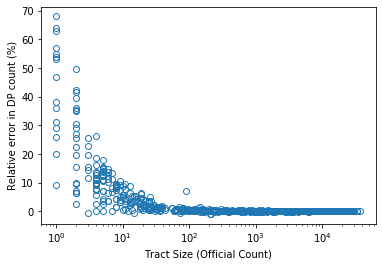

In [38]:
# is the relative error correlated with tract size?  I bet it is
plt.plot(tract_sf, rel_error, 'o', mec='C0', mew=1, color='none')
plt.semilogx()
plt.xlabel('Tract Size (Official Count)')
plt.ylabel('Relative error in DP count (%)');

In [39]:
# quite small for tracts of at least 50 people (which is most of them)
tract_sf[tract_sf > 50].describe()

count    72159.000000
mean      4270.312477
std       1947.067703
min         56.000000
25%       2911.000000
50%       4021.000000
75%       5338.000000
max      37452.000000
Name: P0010001_sf, dtype: float64

In [40]:
tract_error[tract_sf > 50].describe()

count    72159.000000
mean        -0.140703
std         36.324856
min       -772.000000
25%        -20.000000
50%         -1.000000
75%         19.000000
max        714.000000
dtype: float64

In [41]:
# where is that outlier?

rel_error[tract_sf > 50].sort_values()

state  county  tract   
31.0   109.0   3500.0     -0.995283
25.0   25.0    981202.0   -0.985507
36.0   81.0    56100.0    -0.438356
6.0    37.0    980014.0   -0.334728
                             ...   
       111.0   980000.0    1.035714
       1.0     982000.0    1.323944
       73.0    6200.0      1.430556
15.0   5.0     31900.0     6.955556
Length: 72159, dtype: float64

In [ ]:
# state 15, county 5, tract 31900.0
# https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county
# Kalawao County, Hawaii
# find it on https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx
# by using an address from google maps?

![image.png](attachment:image.png)

https://en.wikipedia.org/wiki/Kalawao_County,_Hawaii

Remember this county?  Definitely an outlier.